# Minimum, Maximum, and Mixture

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [1]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [2]:
from utils import set_pyplot_params
set_pyplot_params()

In the previous chapter we computed distributions of sums.
In this chapter, we'll compute distributions of minimums and maximums, and use them to solve both forward and inverse problems.

Then we'll look at distributions that are mixtures of other distributions, which will turn out to be particularly useful for making predictions.

But we'll start with a powerful tool for working with distributions, the cumulative distribution function.

在上一章中，我们计算了和的分布。
在本章中，我们将计算最小值和最大值的分布，并使用它们来解决正向和逆向问题。

然后我们将查看其他分布的混合分布，这对于进行预测特别有用。

但我们将从一个处理分布的强大工具开始，即累积分布函数。

## Cumulative Distribution Functions

So far we have been using probability mass functions to represent distributions.
A useful alternative is the **cumulative distribution function**, or CDF.

As an example, I'll use the posterior distribution from the Euro problem, which we computed in <<_BayesianEstimation>>.

Here's the uniform prior we started with.

## 累积分布函数

到目前为止，我们一直在使用概率质量函数来表示分布。
一个有用的替代方法是**累积分布函数**，或 CDF。

作为一个例子，我将使用我们在 <<_BayesianEstimation>> 中计算的欧元问题的后验分布。

这是我们开始之前的平均先验。

In [3]:
import numpy as np
from empiricaldist import Pmf

hypos = np.linspace(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250

And here's the update.

In [5]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """Update pmf using the binomial distribution."""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [6]:
update_binomial(pmf, data)

The CDF is the cumulative sum of the PMF, so we can compute it like this:
CDF 是 PMF 的累积和，因此我们可以这样计算：

In [7]:
cumulative = pmf.cumsum()

Here's what it looks like, along with the PMF.


In [8]:
from utils import decorate

def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

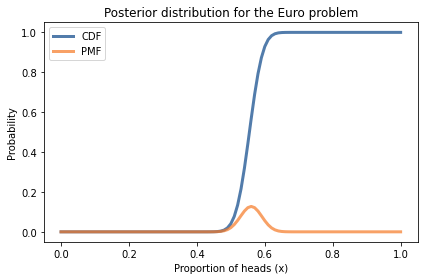

In [9]:
cumulative.plot(label='CDF')
pmf.plot(label='PMF')
decorate_euro(title='Posterior distribution for the Euro problem')

The range of the CDF is always from 0 to 1, in contrast with the PMF, where the maximum can be any probability.

The result from `cumsum` is a Pandas `Series`, so we can use the bracket operator to select an element:

CDF 的范围总是从 0 到 1，而 PMF 的最大值可以是任何概率。

`cumsum` 的结果是 Pandas `Series`，所以我们可以使用括号运算符来选择一个元素：

In [10]:
cumulative[0.61]

0.9638303193984255

The result is about 0.96, which means that the total probability of all quantities less than or equal to 0.61 is 96%.

To go the other way --- to look up a probability and get the corresponding quantile --- we can use interpolation:

结果约为 0.96，这意味着所有小于或等于 0.61 的量的总概率为 96%。

换一种方式——查找概率并获得相应的分位数——我们可以使用插值：

In [11]:
from scipy.interpolate import interp1d

ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps, qs)
interp(0.96)

array(0.60890171)

The result is about 0.61, so that confirms that the 96th percentile of this distribution is 0.61.

`empiricaldist` provides a class called `Cdf` that represents a cumulative distribution function.
Given a `Pmf`, you can compute a `Cdf` like this:

结果约为 0.61，因此证实了该分布的第 96 个百分位数为 0.61。

`empiricaldist` 提供了一个名为 `Cdf` 的类，它表示累积分布函数。
给定一个“Pmf”，你可以像这样计算一个“Cdf”：

In [12]:
cdf = pmf.make_cdf()

`make_cdf` uses `np.cumsum` to compute the cumulative sum of the probabilities.

You can use brackets to select an element from a `Cdf`:

`make_cdf` 使用 `np.cumsum` 来计算概率的累积和。

您可以使用方括号从 `Cdf` 中选择一个元素：

In [13]:
cdf[0.61]

0.9638303193984255

But if you look up a quantity that's not in the distribution, you get a `KeyError`.

但是如果你查找一个不在分布中的数量，你会得到一个“KeyError”。


In [14]:
try:
    cdf[0.615]
except KeyError as e:
    print(repr(e))

KeyError(0.615)


To avoid this problem, you can call a `Cdf` as a function, using parentheses.
If the argument does not appear in the `Cdf`, it interpolates between quantities.

为避免此问题，您可以使用括号将 `Cdf` 作为函数调用。
如果参数没有出现在 `Cdf` 中，它会在数量之间进行插值。

In [15]:
cdf(0.615)

array(0.96383032)

Going the other way, you can use `quantile` to look up a cumulative probability and get the corresponding quantity:

反过来，你可以使用 `quantile` 来查找累积概率并得到相应的数量：


In [16]:
cdf.quantile(0.9638303)

array(0.61)

`Cdf` also provides `credible_interval`, which computes a credible interval that contains the given probability:

`Cdf` 还提供了 `credible_interval`，它计算包含给定概率的可信区间：

In [17]:
cdf.credible_interval(0.9)

array([0.51, 0.61])

CDFs and PMFs are equivalent in the sense that they contain the
same information about the distribution, and you can always convert
from one to the other.
Given a `Cdf`, you can get the equivalent `Pmf` like this:

CDF 和 PMF 是等价的，因为它们包含
有关分布的相同信息，您可以随时转换
从一个到另一个。
给定一个 `Cdf`，你可以得到等价的 `Pmf`，如下所示：

In [18]:
pmf = cdf.make_pmf()

`make_pmf` uses `np.diff` to compute differences between consecutive cumulative probabilities.

One reason `Cdf` objects are useful is that they compute quantiles efficiently.
Another is that they make it easy to compute the distribution of a maximum or minimum, as we'll see in the next section.

`make_pmf` 使用 `np.diff` 来计算连续累积概率之间的差异。

`Cdf` 对象有用的一个原因是它们可以有效地计算分位数。
另一个是它们使计算最大值或最小值的分布变得容易，我们将在下一节中看到。

## Best Three of Four

In *Dungeons & Dragons*, each character has six attributes: strength, intelligence, wisdom, dexterity, constitution, and charisma.

To generate a new character, players roll four 6-sided dice for each attribute and add up the best three.
For example, if I roll for strength and get 1, 2, 3, 4 on the dice, my character's strength would be the sum of 2, 3, and 4, which is 9.

As an exercise, let's figure out the distribution of these attributes.
Then, for each character, we'll figure out the distribution of their best attribute.

I'll import two functions from the previous chapter: `make_die`, which makes a `Pmf` that represents the outcome of rolling a die, and `add_dist_seq`, which takes a sequence of `Pmf` objects and computes the distribution of their sum.

Here's a `Pmf` that represents a six-sided die and a sequence with three references to it.

## 四强中的三强

在 *Dungeons & Dragons* 中，每个角色都有六种属性：力量、智力、智慧、敏捷、体质和魅力。

要生成一个新角色，玩家需要为每个属性掷四个 6 面骰子，然后将最好的三个相加。
例如，如果我掷骰子得到 1、2、3、4，我的角色的力量将是 2、3 和 4 的总和，即 9。

作为练习，让我们弄清楚这些属性的分布。
然后，对于每个角色，我们将计算出他们最佳属性的分布。

我将从上一章中导入两个函数：`make_die`，它生成一个代表掷骰子结果的`Pmf`，以及`add_dist_seq`，它采用一系列`Pmf`对象并计算它们的分布和。

这是一个“Pmf”，它代表一个六面骰子和一个包含三个引用的序列。

In [19]:
from utils import make_die

die = make_die(6)
dice = [die] * 3

In [23]:
dice

[1    0.166667
 2    0.166667
 3    0.166667
 4    0.166667
 5    0.166667
 6    0.166667
 Name: , dtype: float64,
 1    0.166667
 2    0.166667
 3    0.166667
 4    0.166667
 5    0.166667
 6    0.166667
 Name: , dtype: float64,
 1    0.166667
 2    0.166667
 3    0.166667
 4    0.166667
 5    0.166667
 6    0.166667
 Name: , dtype: float64]

And here's the distribution of the sum of three dice.
这是三个骰子总和的分布。

In [20]:
from utils import add_dist_seq

pmf_3d6 = add_dist_seq(dice)

Here's what it looks like:

In [21]:
def decorate_dice(title=''):
    decorate(xlabel='Outcome',
             ylabel='PMF',
             title=title)

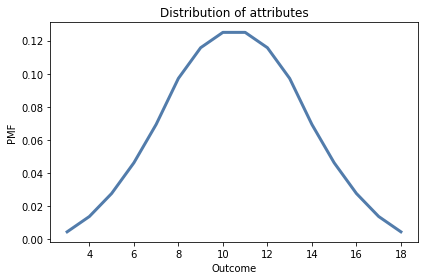

In [22]:
pmf_3d6.plot()
decorate_dice('Distribution of attributes')

If we roll four dice and add up the best three, computing the distribution of the sum is a bit more complicated.
I'll estimate the distribution by simulating 10,000 rolls.

First I'll create an array of random values from 1 to 6, with 10,000 rows and 4 columns:

如果我们掷四个骰子并将最好的三个相加，计算总和的分布就有点复杂了。
我将通过模拟 10,000 卷来估计分布。

首先，我将创建一个从 1 到 6 的随机值数组，包含 10,000 行和 4 列：

In [83]:
n = 10000
a = np.random.randint(1, 7, size=(n, 4)) ### 直接进行模拟抽样

In [30]:
a

array([[2, 3, 4, 6],
       [2, 2, 3, 3],
       [1, 3, 4, 4],
       ...,
       [1, 1, 5, 6],
       [1, 2, 3, 4],
       [3, 5, 6, 6]])

To find the best three outcomes in each row, I'll use `sort` with `axis=1`, which sorts the rows in ascending order.

为了在每行中找到最好的三个结果，我将使用 `sort` 和 `axis=1`，它按升序对行进行排序。

In [82]:
a.sort(axis=1)  ### 按行进行排序

Finally, I'll select the last three columns and add them up.

最后，我将选择最后三列并将它们相加。

In [26]:
t = a[:, 1:].sum(axis=1)

In [80]:
t

array([13,  8, 11, ..., 12,  9, 17])

Now `t` is an array with a single column and 10,000 rows.
We can compute the PMF of the values in `t` like this:

现在 `t` 是一个具有单列和 10,000 行的数组。
我们可以像这样计算 `t` 中的值的 PMF：

In [31]:
pmf_best3 = Pmf.from_seq(t)

In [81]:
pmf_best3

,probs
3,0.0011
4,0.0029
5,0.0064
6,0.0154
7,0.0287
8,0.0465
9,0.0696
10,0.0930
11,0.1112
12,0.1351


The following figure shows the distribution of the sum of three dice, `pmf_3d6`, and the distribution of the best three out of four, `pmf_best3`.

下图显示了三个骰子之和“pmf_3d6”的分布，以及四个骰子中最好的三个“pmf_best3”的分布。

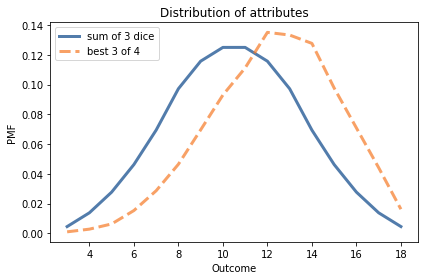

In [28]:
pmf_3d6.plot(label='sum of 3 dice')
pmf_best3.plot(label='best 3 of 4', ls='--')

decorate_dice('Distribution of attributes')

As you might expect, choosing the best three out of four tends to yield higher values.

Next we'll find the distribution for the maximum of six attributes, each the sum of the best three of four dice.

如您所料，从四个中选择最好的三个往往会产生更高的值。

接下来，我们将找到最多六个属性的分布，每个属性是四个骰子中最好的三个的总和。

## Maximum

To compute the distribution of a maximum or minimum, we can make good use of the cumulative distribution function.
First, I'll compute the `Cdf` of the best three of four distribution:

## 最大化

为了计算最大值或最小值的分布，我们可以很好地利用累积分布函数。
首先，我将计算四个分布中最好的三个的“Cdf”：

In [32]:
cdf_best3 = pmf_best3.make_cdf()

Recall that `Cdf(x)` is the sum of probabilities for quantities less than or equal to `x`.
Equivalently, it is the probability that a random value chosen from the distribution is less than or equal to `x`.

Now suppose I draw 6 values from this distribution.
The probability that all 6 of them are less than or equal to `x` is `Cdf(x)` raised to the 6th power, which we can compute like this:

回想一下，“Cdf(x)”是小于或等于“x”的数量的概率之和。
等效地，它是从分布中选择的随机值小于或等于“x”的概率。

现在假设我从这个分布中抽取 6 个值。
所有 6 个都小于或等于“x”的概率是“Cdf(x)”的 6 次方，我们可以这样计算：

In [33]:
cdf_best3**6

3     1.771561e-18
4     4.096000e-15
5     1.265319e-12
6     2.949295e-10
7     2.620469e-08
8     1.061520e-06
9     2.465325e-05
10    3.354845e-04
11    2.772027e-03
12    1.757560e-02
13    7.080700e-02
14    2.098883e-01
15    4.294563e-01
16    6.876710e-01
17    9.060998e-01
18    1.000000e+00
Name: , dtype: float64

If all 6 values are less than or equal to `x`, that means that their maximum is less than or equal to `x`.
So the result is the CDF of their maximum.
We can convert it to a `Cdf` object, like this:

如果所有 6 个值都小于或等于 `x`，则意味着它们的最大值小于或等于 `x`。
所以结果是它们的最大值的 CDF。
我们可以将其转换为 `Cdf` 对象，如下所示：

In [35]:
from empiricaldist import Cdf

cdf_max6 = Cdf(cdf_best3**6)

And compute the equivalent `Pmf` like this:

并像这样计算等效的“Pmf”：

In [36]:
pmf_max6 = cdf_max6.make_pmf()

The following figure shows the result.

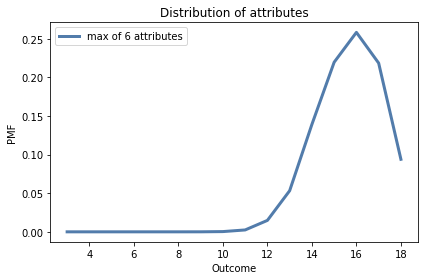

In [84]:
pmf_max6.plot(label='max of 6 attributes')
decorate_dice('Distribution of attributes')

Most characters have at least one attribute greater than 12; almost 10% of them have an 18.

大多数字符至少有一个大于 12 的属性；10% 左右有 18 

The following figure shows the CDFs for the three distributions we have computed.

下图显示了我们计算的三个分布的 CDF。

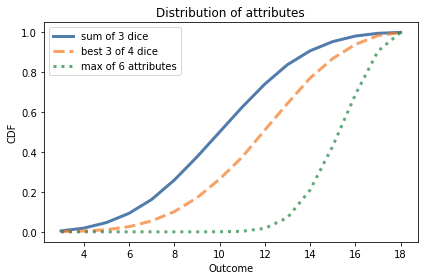

In [38]:
import matplotlib.pyplot as plt

cdf_3d6 = pmf_3d6.make_cdf()
cdf_3d6.plot(label='sum of 3 dice')

cdf_best3 = pmf_best3.make_cdf()
cdf_best3.plot(label='best 3 of 4 dice', ls='--')

cdf_max6.plot(label='max of 6 attributes', ls=':')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

`Cdf` provides `max_dist`, which does the same computation, so we can also compute the `Cdf` of the maximum like this:

`Cdf` 提供了 `max_dist`，它执行相同的计算，因此我们也可以像这样计算最大值的 `Cdf`：

In [39]:
cdf_max_dist6 = cdf_best3.max_dist(6)

And we can confirm that the differences are small.

我们可以确认差异很小。

In [40]:
np.allclose(cdf_max_dist6, cdf_max6)

True

In the next section we'll find the distribution of the minimum.
The process is similar, but a little more complicated.
See if you can figure it out before you go on.

在下一节中，我们将找到最小值的分布。
过程类似，但稍微复杂一些。
在你继续之前，看看你是否能弄清楚。

## Minimum

In the previous section we computed the distribution of a character's best attribute.
Now let's compute the distribution of the worst.

To compute the distribution of the minimum, we'll use the **complementary CDF**, which we can compute like this:

## 最低限度

在上一节中，我们计算了角色最佳属性的分布。
现在让我们计算最差的分布。

为了计算最小值的分布，我们将使用 **complementary CDF**，我们可以这样计算：

In [41]:
prob_gt = 1 - cdf_best3

As the variable name suggests, the complementary CDF is the probability that a value from the distribution is greater than `x`.
If we draw 6 values from the distribution, the probability that all 6 exceed `x` is:

正如变量名所暗示的，互补 CDF 是分布中的值大于“x”的概率。
如果我们从分布中抽取 6 个值，所有 6 个值都超过 `x` 的概率为：

In [42]:
prob_gt6 = prob_gt**6

If all 6 exceed `x`, that means their minimum exceeds `x`, so `prob_gt6` is the complementary CDF of the minimum.
And that means we can compute the CDF of the minimum like this:

如果所有 6 个都超过了 `x`，这意味着它们的最小值超过了 `x`，所以 `prob_gt6` 是最小值的互补 CDF。
这意味着我们可以像这样计算最小值的 CDF：

In [43]:
prob_le6 = 1 - prob_gt6

The result is a Pandas `Series` that represents the CDF of the minimum of six attributes.  We can put those values in a `Cdf` object like this:

结果是一个代表最少六个属性的 CDF 的 Pandas `Series`。我们可以将这些值放在一个 `Cdf` 对象中，如下所示：

In [44]:
cdf_min6 = Cdf(prob_le6)

Here's what it looks like, along with the distribution of the maximum.

这是它的样子，以及最大值的分布。

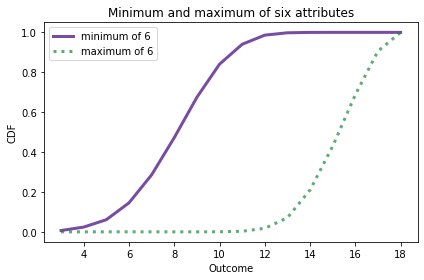

In [45]:
cdf_min6.plot(color='C4', label='minimum of 6')
cdf_max6.plot(color='C2', label='maximum of 6', ls=':')
decorate_dice('Minimum and maximum of six attributes')
plt.ylabel('CDF');

`Cdf` provides `min_dist`, which does the same computation, so we can also compute the `Cdf` of the minimum like this:

`Cdf` 提供了 `min_dist`，它执行相同的计算，因此我们也可以像这样计算最小值的 `Cdf`：

In [46]:
cdf_min_dist6 = cdf_best3.min_dist(6)

And we can confirm that the differences are small.
我们可以确认差异很小。

In [47]:
np.allclose(cdf_min_dist6, cdf_min6)

True

In the exercises at the end of this chapter, you'll use distributions of the minimum and maximum to do Bayesian inference.
But first we'll see what happens when we mix distributions.

在本章末尾的练习中，您将使用最小值和最大值的分布来进行贝叶斯推理。
但首先我们将看看当我们混合分布时会发生什么。

## Mixture

In this section I'll show how we can compute a distribution which is a mixture of other distributions.
I'll explain what that means with some simple examples;
then, more usefully, we'll see how these mixtures are used to make predictions.

Here's another example inspired by *Dungeons & Dragons*:

* Suppose your character is armed with a dagger in one hand and a short sword in the other.

* During each round, you attack a monster with one of your two weapons, chosen at random.

* The dagger causes one 4-sided die of damage; the short sword causes one 6-sided die of damage.

What is the distribution of damage you inflict in each round?

To answer this question, I'll make a `Pmf` to represent the 4-sided and 6-sided dice:

## 混合

在本节中，我将展示我们如何计算一个混合了其他分布的分布。
我将通过一些简单的例子来解释这意味着什么；
然后，更有用的是，我们将看到如何使用这些混合物进行预测。

这是另一个受 *Dungeons & Dragons* 启发的示例：

* 假设你的角色一只手拿着匕首，另一只手拿着短剑。

* 在每一轮中，你使用随机选择的两种武器中的一种攻击怪物。

* 匕首造成一个 4 面伤害骰子；短剑造成 1 个 6 面伤害死亡。

你在每一轮中造成的伤害分布是什么？

为了回答这个问题，我将制作一个“Pmf”来表示 4 面和 6 面骰子：

In [48]:
d4 = make_die(4)
d6 = make_die(6)

Now, let's compute the probability you inflict 1 point of damage.

* If you attacked with the dagger, it's 1/4.

* If you attacked with the short sword, it's 1/6.

Because the probability of choosing either weapon is 1/2, the total probability is the average:

现在，让我们计算一下你造成 1 点伤害的概率。

* 如果你用匕首攻击，它是 1/4。

* 如果你用短剑攻击，它是 1/6。

因为选择任一武器的概率是 1/2，所以总概率是平均值：

In [49]:
prob_1 = (d4(1) + d6(1)) / 2
prob_1

0.20833333333333331

For the outcomes 2, 3, and 4, the probability is the same, but for 5 and 6 it's different, because those outcomes are impossible with the 4-sided die.

对于结果 2、3 和 4，概率是相同的，但对于 5 和 6，它是不同的，因为这些结果对于 4 面骰子是不可能的。

In [50]:
prob_6 = (d4(6) + d6(6)) / 2
prob_6

0.08333333333333333

To compute the distribution of the mixture, we could loop through the possible outcomes and compute their probabilities.

But we can do the same computation using the `+` operator:

为了计算混合分布，我们可以遍历可能的结果并计算它们的概率。

但是我们可以使用 `+` 运算符进行相同的计算：

In [51]:
mix1 = (d4 + d6) / 2

Here's what the mixture of these distributions looks like.

以下是这些分布的混合情况。

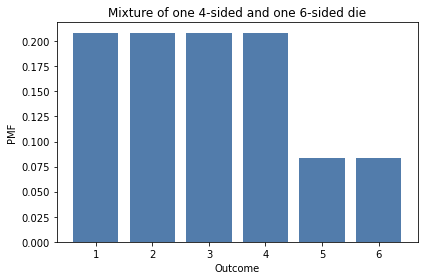

In [52]:
mix1.bar(alpha=0.7)
decorate_dice('Mixture of one 4-sided and one 6-sided die')

Now suppose you are fighting three monsters:

* One has a club, which causes one 4-sided die of damage.

* One has a mace, which causes one 6-sided die.

* And one has a quarterstaff, which also causes one 6-sided die. 

Because the melee is disorganized, you are attacked by one of these monsters each round, chosen at random.
To find the distribution of the damage they inflict, we can compute a weighted average of the distributions, like this:

现在假设您正在与三个怪物战斗：

* 一个人有一个球杆，它会导致一个 4 面的伤害骰子。

* 一个人有一个狼牙棒，这会导致一个 6 面骰子。

* 一个有四杖，这也会导致一个 6 面骰子。

因为混战是杂乱无章的，所以每轮你都会被这些怪物中的一个随机选择攻击。
为了找出它们造成的伤害的分布，我们可以计算分布的加权平均值，如下所示：

In [53]:
mix2 = (d4 + 2*d6) / 3

This distribution is a mixture of one 4-sided die and two 6-sided dice.
Here's what it looks like.

这种分布是一个 4 面骰子和两个 6 面骰子的混合。
这是它的样子。

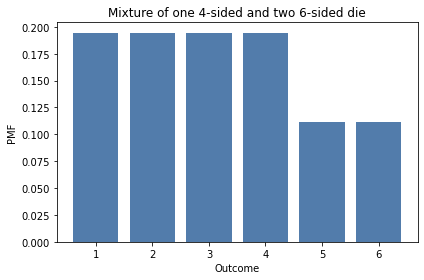

In [54]:
mix2.bar(alpha=0.7)
decorate_dice('Mixture of one 4-sided and two 6-sided die')

In this section we used the `+` operator, which adds the probabilities in the distributions, not to be confused with `Pmf.add_dist`, which computes the distribution of the sum of the distributions.

To demonstrate the difference, I'll use `Pmf.add_dist` to compute the distribution of the total damage done per round, which is the sum of the two mixtures:

在本节中，我们使用了 `+` 运算符，它添加了分布中的概率，不要与 `Pmf.add_dist` 混淆，后者计算分布总和的分布。

为了演示差异，我将使用“Pmf.add_dist”来计算每轮造成的总伤害的分布，这是两种混合的总和：

In [55]:
total_damage = Pmf.add_dist(mix1, mix2)

And here's what it looks like.
这就是它的样子。

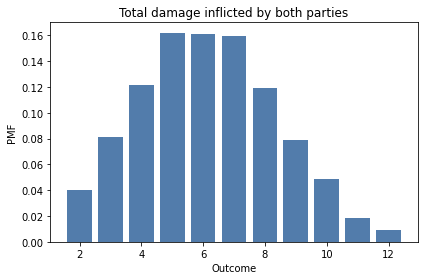

In [56]:
total_damage.bar(alpha=0.7)
decorate_dice('Total damage inflicted by both parties')

## General Mixtures

In the previous section we computed mixtures in an *ad hoc* way.
Now we'll see a more general solution.
In future chapters, we'll use this solution to generate predictions for real-world problems, not just role-playing games.
But if you'll bear with me, we'll continue the previous example for one more section.

Suppose three more monsters join the combat, each of them with a battle axe that causes one 8-sided die of damage.
Still, only one monster attacks per round, chosen at random, so the damage they inflict is a mixture of:

* One 4-sided die,
* Two 6-sided dice, and
* Three 8-sided dice.

I'll use a `Pmf` to represent a randomly chosen monster:

## 一般混合

在上一节中，我们以 *ad hoc* 方式计算了混合。
现在我们将看到一个更通用的解决方案。
在以后的章节中，我们将使用这个解决方案来生成对现实世界问题的预测，而不仅仅是角色扮演游戏。
但是，如果您能容忍我，我们将继续前面的示例进行另一节。

假设另外三个怪物加入战斗，每个怪物都有一把能造成一个 8 面伤害死亡的战斧。
尽管如此，每轮只有一个怪物攻击，随机选择，所以他们造成的伤害是混合的：

* 一个 4 面模具，
* 两个 6 面骰子，以及
* 三个 8 面骰子。

我将使用 `Pmf` 来表示随机选择的怪物：

In [69]:
hypos = [4,6,8]
counts = [1,2,3]
pmf_dice = Pmf(counts, hypos)
pmf_dice.normalize()
pmf_dice

,probs
4,0.166667
6,0.333333
8,0.500000


This distribution represents the number of sides on the die we'll roll and the probability of rolling each one.
For example, one of the six monsters has a dagger, so the probability is $1/6$ that we roll a 4-sided die.

Next I'll make a sequence of `Pmf` objects to represent the dice:

此分布表示我们将掷骰子的面数以及掷骰子的概率。
例如，六个怪物中的一个有一把匕首，所以我们掷出一个 4 面骰子的概率是 $1/6$。

接下来，我将制作一系列“Pmf”对象来表示骰子：

In [70]:
dice = [make_die(sides) for sides in hypos]

To compute the distribution of the mixture, I'll compute the weighted average of the dice, using the probabilities in `pmf_dice` as the weights.

To express this computation concisely, it is convenient to put the distributions into a Pandas `DataFrame`:


为了计算混合的分布，我将使用“pmf_dice”中的概率作为权重来计算骰子的加权平均值。

为了简洁地表达这个计算，将分布放入 Pandas `DataFrame` 是很方便的：

In [71]:
import pandas as pd

pd.DataFrame(dice)

,1,2,3,4,5,6,7,8
,0.250000,0.250000,0.250000,0.250000,NaN,NaN,NaN,NaN
,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,NaN,NaN
,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125


The result is a `DataFrame` with one row for each distribution and one column for each possible outcome.
Not all rows are the same length, so Pandas fills the extra spaces with the special value `NaN`, which stands for "not a number".
We can use `fillna` to replace the `NaN` values with 0.

结果是一个“DataFrame”，每个分布一行，每个可能结果一列。
并非所有行的长度都相同，因此 Pandas 用特殊值 `NaN` 填充额外的空格，它代表“非数字”。
我们可以使用 `fillna` 将 `NaN` 值替换为 0。

The next step is to multiply each row by the probabilities in `pmf_dice`, which turns out to be easier if we transpose the matrix so the distributions run down the columns rather than across the rows:

下一步是将每一行乘以 pmf_dice 中的概率，如果我们转置矩阵，则结果会更容易，这样分布会顺着列而不是跨行：

In [72]:
df = pd.DataFrame(dice).fillna(0).transpose()

In [60]:
df

,,,
1,0.166667,0.166667,0.166667
2,0.166667,0.166667,0.166667
3,0.166667,0.166667,0.166667
4,0.166667,0.166667,0.166667
5,0.166667,0.166667,0.166667
6,0.166667,0.166667,0.166667


Now we can multiply by the probabilities in `pmf_dice`:


In [73]:
df *= pmf_dice.ps

In [74]:
df

,,,
1,0.041667,0.055556,0.0625
2,0.041667,0.055556,0.0625
3,0.041667,0.055556,0.0625
4,0.041667,0.055556,0.0625
5,0.000000,0.055556,0.0625
6,0.000000,0.055556,0.0625
7,0.000000,0.000000,0.0625
8,0.000000,0.000000,0.0625


And add up the weighted distributions:

In [75]:
df.sum(axis=1)

1    0.159722
2    0.159722
3    0.159722
4    0.159722
5    0.118056
6    0.118056
7    0.062500
8    0.062500
dtype: float64

The argument `axis=1` means we want to sum across the rows.
The result is a Pandas `Series`.

Putting it all together, here's a function that makes a weighted mixture of distributions.

该参数意味着我们要跨行求和。结果是Pandas `Series`.

把它们放在一起，这里有一个函数，可以形成分布的加权混合。

In [67]:
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

The first parameter is a `Pmf` that maps from each hypothesis to a probability.
The second parameter is a sequence of `Pmf` objects, one for each hypothesis.
We can call it like this:

第一个参数是从每个假设映射到概率的pmf参数。第二个参数是一系列pmf对象，每个假设一个。我们可以这样称呼它：

In [76]:
mix = make_mixture(pmf_dice, dice)

And here's what it looks like.

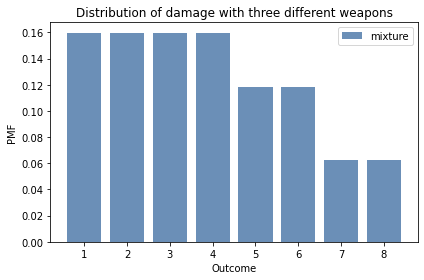

In [77]:
mix.bar(label='mixture', alpha=0.6)
decorate_dice('Distribution of damage with three different weapons')

In this section I used Pandas so that `make_mixture` is concise, efficient, and hopefully not too hard to understand.
In the exercises at the end of the chapter, you'll have a chance to practice with mixtures, and we will use `make_mixture` again in the next chapter.

在本节中，我使用了Pandas，因此简洁，高效，并且希望不会太难理解。在本章末尾的练习中，您将有机会使用混合分布进行练习，我们将在下一章中再次使用make_mixture

## Summary

This chapter introduces the `Cdf` object, which represents the cumulative distribution function (CDF).

A `Pmf` and the corresponding `Cdf` are equivalent in the sense that they contain the same information, so you can convert from one to the other.  
The primary difference between them is performance: some operations are faster and easier with a `Pmf`; others are faster with a `Cdf`.

In this chapter we used `Cdf` objects to compute distributions of maximums and minimums; these distributions are useful for inference if we are given a maximum or minimum as data.
You will see some examples in the exercises, and in future chapters.
We also computed mixtures of distributions, which we will use in the next chapter to make predictions.

But first you might want to work on these exercises.
## 概括

本章介绍了`Cdf`对象，它代表了累积分布函数（CDF）。

`Pmf` 和相应的 `Cdf` 在它们包含相同信息的意义上是等价的，因此您可以从一个转换为另一个。
它们之间的主要区别在于性能：一些操作使用 `Pmf` 更快更容易；一些操作使用“Cdf”更快。

在本章中，我们使用“Cdf”对象来计算最大值和最小值的分布；如果我们得到最大值或最小值作为数据，这些分布对于推理很有用。
您将在练习和以后的章节中看到一些示例。
我们还计算了分布的混合，我们将在下一章中使用它来进行预测。

但首先你可能想要做这些练习。

## Exercises

**Exercise:** When you generate a D&D character, instead of rolling dice, you can use the "standard array" of attributes, which is 15, 14, 13, 12, 10, and 8.
Do you think you are better off using the standard array or (literally) rolling the dice?

Compare the distribution of the values in the standard array to the distribution we computed for the best three out of four:

* Which distribution has higher mean?  Use the `mean` method.

* Which distribution has higher standard deviation?  Use the `std` method.

* The lowest value in the standard array is 8.  For each attribute, what is the probability of getting a value less than 8?  If you roll the dice six times, what's the probability that at least one of your attributes is less than 8?

* The highest value in the standard array is 15.  For each attribute, what is the probability of getting a value greater than 15?  If you roll the dice six times, what's the probability that at least one of your attributes is greater than 15?

**练习：**当你生成一个 D&D 角色时，你可以使用属性的“标准数组”来代替掷骰子，即 15、14、13、12、10 和 8。
你认为你最好使用标准数组还是（字面上）掷骰子？

将标准数组中值的分布与我们计算的四个中最好的三个的分布进行比较：

* 哪个分布的均值更高？使用 `mean` 方法。

* 哪个分布有更高的标准差？使用 `std` 方法。

* 标准数组中的最小值是 8。对于每个属性，得到小于 8 的值的概率是多少？如果你掷骰子六次，你的至少一个属性小于 8 的概率是多少？

* 标准数组中的最大值是15。对于每个属性，得到大于15的值的概率是多少？如果你掷骰子六次，你的至少一个属性大于 15 的概率是多少？

To get you started, here's a `Cdf` that represents the distribution of attributes in the standard array:

为了帮助您入门，这里有一个表示标准数组中属性分布的“Cdf”：

In [78]:
standard = [15,14,13,12,10,8]
cdf_standard = Cdf.from_seq(standard)

In [79]:
cdf_standard

,probs
8,0.166667
10,0.333333
12,0.500000
13,0.666667
14,0.833333
15,1.000000


We can compare it to the distribution of attributes you get by rolling four dice at adding up the best three.

我们可以将其与您通过掷四个骰子将最好的三个相加而获得的属性分布进行比较。

In [64]:
cdf_best3.plot(label='best 3 of 4', color='C1', ls='--')
cdf_standard.step(label='standard set', color='C7')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

I plotted `cdf_standard` as a step function to show more clearly that it contains only a few quantities.

我将 `cdf_standard` 绘制为一个阶跃函数，以更清楚地表明它只包含几个数量级。

In [65]:
# Solution goes here

In [66]:
# Solution goes here

In [67]:
# Solution goes here

In [68]:
# Solution goes here

In [69]:
# Solution goes here

In [70]:
# Solution goes here

**Exercise:** Suppose you are fighting three monsters:

* One is armed with a short sword that causes one 6-sided die of damage,

* One is armed with a battle axe that causes one 8-sided die of damage, and

* One is armed with a bastard sword that causes one 10-sided die of damage.

One of the monsters, chosen at random, attacks you and does 1 point of damage.

Which monster do you think it was?  Compute the posterior probability that each monster was the attacker.

If the same monster attacks you again, what is the probability that you suffer 6 points of damage?

Hint: Compute a posterior distribution as we have done before and pass it as one of the arguments to `make_mixture`.

**练习**： 假设你正在与三个怪物战斗：

* 一个人手持短剑，造成一个 6 面伤害骰子，

* 一个人手持战斧，造成一个 8 面伤害骰子，并且

* 一个人手持一把能造成 1 个 10 面伤害骰子的混蛋剑。

随机选择的其中一只怪物攻击你并造成 1 点伤害。

你以为是哪个怪物？ 计算每个怪物是攻击者的后验概率。

如果同一个怪物再次攻击你，你受到6点伤害的概率是多少？

提示：像我们之前所做的那样计算后验分布，并将其作为参数之一传递给“make_mixture”。

In [71]:
# Solution goes here

In [72]:
# Solution goes here

In [73]:
# Solution goes here

In [74]:
# Solution goes here

**Exercise:** Henri Poincaré was a French mathematician who taught at the Sorbonne around 1900. The following anecdote about him is probably fiction, but it makes an interesting probability problem.

Supposedly Poincaré suspected that his local bakery was selling loaves of bread that were lighter than the advertised weight of 1 kg, so every day for a year he bought a loaf of bread, brought it home and weighed it. At the end of the year, he plotted the distribution of his measurements and showed that it fit a normal distribution with mean 950 g and standard deviation 50 g. He brought this evidence to the bread police, who gave the baker a warning.

For the next year, Poincaré continued to weigh his bread every day. At the end of the year, he found that the average weight was 1000 g, just as it should be, but again he complained to the bread police, and this time they fined the baker.

Why? Because the shape of the new distribution was asymmetric. Unlike the normal distribution, it was skewed to the right, which is consistent with the hypothesis that the baker was still making 950 g loaves, but deliberately giving Poincaré the heavier ones.

To see whether this anecdote is plausible, let's suppose that when the baker sees Poincaré coming, he hefts `n` loaves of bread and gives Poincaré the heaviest one.  How many loaves would the baker have to heft to make the average of the maximum 1000 g?

**练习：** Henri Poincaré 是一位法国数学家，1900 年左右在索邦大学任教。以下关于他的轶事可能是虚构的，但它提出了一个有趣的概率问题。

据说庞加莱怀疑他当地的面包店出售的面包重量比广告上的 1 公斤还轻，所以一年来他每天都买一条面包，带回家称重。在年底，他绘制了他的测量值的分布，并表明它符合平均值 950 g 和标准偏差 50 g 的正态分布。他将这些证据带给面包警察，后者警告了面包师。

在接下来的一年里，庞加莱继续每天称他的面包。年底，他发现平均重量是 1000 克，应该是这样，但他再次向面包警察投诉，这次他们对面包师进行了罚款。

为什么？因为新分布的形状是不对称的。与正态分布不同，它向右偏斜，这与面包师仍在制作 950 克面包但故意让庞加莱重的面包的假设一致。

为了看看这个轶事是否合理，让我们假设当面包师看到庞加莱来时，他拿起了“n”条面包，给了庞加莱最重的一个。面包师需要举起多少条面包才能平均达到最大 1000 克？

To get you started, I'll generate a year's worth of data from a normal distribution with the given parameters.

为了让您开始，我将从具有给定参数的正态分布中生成一年的数据。

In [75]:
mean = 950
std = 50

np.random.seed(17)
sample = np.random.normal(mean, std, size=365)

In [76]:
# Solution goes here

In [77]:
# Solution goes here